# PREDIÇÃO DA RECEITA DE UM FILME


## PROPOSTA

Neste projeto, a proposta é prever a receita de um filme, a partir de uma analise de um Modelo de Regressão Simples, que faz uso principalmente de um resultado de regressão linear entre duas variáveis quantitativas.

Importando as bibliotecas que serão utilizadas:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split
from datetime import datetime

Lendo nosso dataset csv e armazenando na variável "metadados" que será utlizada:

In [2]:
metadados = pd.read_csv('movies_metadata.csv')
metadados.head(3)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


Ao ser convertida, a coluna 'id' ficou com o formato de obj. Para poder filtrar o nosso dataset apenas com os filmes que estao no dataset small_links, precisamos transformar essa coluna no formato de 'int'. 


**obs**: Para transformar em 'int' foi preciso remover as linhas 19730,29503 e 35587, pois não estavam de acordo com a padrao da coluna.

In [3]:
metadados = metadados.drop([19730, 29503, 35587])
metadados['id'] = metadados['id'].astype('int')

In [4]:
metadados['budget'] = metadados['budget'].astype('int')

In [5]:
links = pd.read_csv('links_small.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].rename(columns={'tmdbId': 'id'}).astype('int')
links.head()

TypeError: rename() got an unexpected keyword argument 'columns'

In [ ]:
smd = metadados[metadados['id'].isin(links)]
smd.head()

Lendo smd; nosso dataset só com as variáveis que selecionamos do original:

In [ ]:
smd.describe()

In [ ]:
smd.dtypes

In [6]:
stats.probplot(smd.revenue, dist='expon', plot=plt);

NameError: name 'smd' is not defined

In [7]:
mu = rs.revenue.mean()
x = np.linspace(0,10**9,100000)
y = stats.expon.pdf(x, scale=mu)
plt.plot(x, y, color='r')
rs.revenue.plot.hist(density = True, bins = 100)
plt.ylabel('densidade')
plt.xlabel('valores de x')
plt.title('Função densidade de probabilidade')
plt.show()

NameError: name 'rs' is not defined

A partir dos gráficos acima, observa-se que a variável revenue distribui-se de forma similar a uma exponencial

## Modelo de Regressao simples

O nosso objetivo em um primeiro momento é prever a receita de um filme em função do seu orcamento, a partir do modelo de regressao linear simples. Neste caso sao definidas como variáveis:


* ***y -*** **Variável independente (explicativa)**: Budget
* ***x -*** **Variável dependente (target)**: Revenue
 

### Teste de hipótese e suposicoes do modelo

Para avaliar a significancia da regressao vamos realizar um teste de hipotes. Assumindo que:

* H0: β1 = 0 - nao ha relacao entre receita e orcamento
* HA: β1 ≠ 0 - há relacao entre receita e orcamento


Para realizar o teste de hipóteses é necessário analisar a distribuicao dos erros, além das seguintes suposicoes do modelo:

* Os erros têm distribuição normal com média e variânciaconstante, ou seja, ei ~ N(0,s2).
* Os erros são independentes entre si, ou seja, Corr(ei , ej) = 0, para qualquer i ≠ j.
* O modelo é linear nos parâmetros.
* Homocedasticidade: Var(ei) = s2 para qualquer i


In [8]:
rs = metadados[['title', 'budget', 'revenue']].set_index('title')
rs.describe()

,budget,revenue
count,4.546300e+04,4.546000e+04
mean,4.224579e+06,1.120935e+07
std,1.742413e+07,6.433225e+07
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,3.800000e+08,2.787965e+09


Ao analisar o describe das duas variaveis , é possivel observar que mais de 75% (38052 filmes) dos dados tem valores iguais a zero, possivelmente indica uma falta de dados. Como isso nao é bom para nossa análise, vamos fazer uma limpeza nos dados

In [9]:
rs[rs['revenue'] == 0].shape

(38052, 2)

In [10]:
rs.shape

(45463, 2)

In [11]:
rs['revenue'] = rs['revenue'].replace(0, np.nan)
rs['budget'] = rs['budget'].replace(0, np.nan)
rs = rs[['budget','revenue']].dropna()

rs.shape

(5381, 2)

In [12]:
rs.describe()

,budget,revenue
count,5.381000e+03,5.381000e+03
mean,3.109480e+07,9.031812e+07
std,4.016263e+07,1.661423e+08
min,1.000000e+00,1.000000e+00
25%,5.037000e+06,7.011317e+06
50%,1.700000e+07,2.991874e+07
75%,4.000000e+07,9.996575e+07
max,3.800000e+08,2.787965e+09


Feita a limpeza, o que nos resta sao dados de 5381 filmes, que corresponde a cerca de 11% do nosso dataframe original, o que ainda é um conjunto considerável de dados. A partir deste novo conjunto de dados, vamos fazer um gráfico de dispercao com as duas variaveis para realizar uma primeira análise:

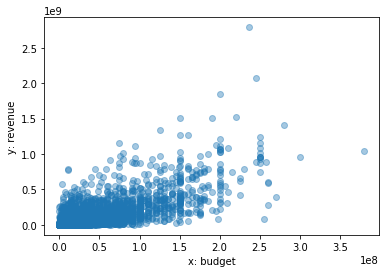

In [13]:
x_dados = rs.budget # Definindo budget como explicativa
y_dados = rs.revenue   # Definindo revenue como resposta

plt.scatter(x_dados,y_dados, alpha=0.4);
plt.xlabel("x: budget");
plt.ylabel("y: revenue");

A partir do gráfico acima, observa-se que uma reta pode ser um bom ajuste neste caso. Seguindo a diante em nosso modelo de regressao, vamos utilizar a funcao OLS da biblioteca ststsmodel, para definir os valore de beta1 e beta0, baseado no método dos mínimos quadrados.

In [14]:
# Matriz de 1s e valores de x_dados
X_dados = sm.add_constant(x_dados) # Adiciona coluna de 1s para estimar intercepto junto com a coluna de x (dados)

In [15]:
# Define o modelo
model = sm.OLS(y_dados, X_dados)    

# Faz o ajuste
results = model.fit()   

# Mostra os resultados
results.summary()     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6146.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:11:12   Log-Likelihood:            -1.0744e+05
No. Observations:                5381   AIC:                         2.149e+05
Df Residuals:                    5379   BIC:                         2.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.617e+06   1.96e+06     -1.848      0.065   -7.45e+06    2.19e+05
budget         3.0209      0.039     78.400      0.000       2.945       3.096
==============================================================================
Omnibus:                     4638.631   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357550.028
Skew:                           3.709   Prob(JB):                         0.00
Kurtosis:                      42.239   Cond. No.                     6.42e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ou poderíamos utilizar a funcao regress criada, que aguliza o process

In [16]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

results = regress(X_dados,y_dados)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     6146.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:11:12   Log-Likelihood:            -1.0744e+05
No. Observations:                5381   AIC:                         2.149e+05
Df Residuals:                    5379   BIC:                         2.149e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.617e+06   1.96e+06     -1.848      0.065   -7.45e+06    2.19e+05
budget         3.0209      0.039     78.400      0.000       2.945       3.096
==============================================================================
Omnibus:                     4638.631   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           357550.028
Skew:                           3.709   Prob(JB):                         0.00
Kurtosis:                      42.239   Cond. No.                     6.42e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.42e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Definicao de b0 e b1

Como beta1 não é igual a zero, podemos rejeitar a hipotese nula, ou seja, há uma relacao entre x e y.

In [17]:
beta0 = results.params['const']
beta1 = results.params['budget']

print("Estimativa de beta0 (coeficente linear): {0}".format(beta0))
print("Estimativa de beta1 (coeficente angular): {0}".format(beta1))

Estimativa de beta0 (coeficente linear): -3617362.405904342
Estimativa de beta1 (coeficente angular): 3.0209391248649116


Para avaliar a significancia da regressao vamos realizar um teste de hipotes. Assumindo que:
- Se o valor p for menor que o nivel de significancia escolhido, podemos dizer que x é relevante na analise
- erros tem distribuicao normal com media e variancia constantes
- os erros sao independentes entre si corr = 0

#### Análise valor p

Definindo o nivel de significancia em 10%, temos que o valor-p é menor que alfa, logo rejeita-se H0

In [18]:
valorp_beta0 = results.pvalues['const']
valorp_beta1 = results.pvalues['budget']

print('Valor-p sob H0: beta0 = 0: {:.6f}'.format(valorp_beta0))
print('Valor-p sob H0: beta1 = 0: {:.6f}'.format(valorp_beta1))

Valor-p sob H0: beta0 = 0: 0.064606
Valor-p sob H0: beta1 = 0: 0.000000


In [19]:
#valores preditos de receita
ypredict = results.predict(X_dados).to_frame()

#### Análise teste Omnibus e Jarque-bera
Em ambos os testes analisaremos a normalidade dos residuos. Como o valor Prob(JB) e Prob(Ominibus) sao muito baixos, existe evidencia que os residuos não seguem uma distribuição normal, infringindo uma das suposições do modelo.



### Reta com os valores de y preditos

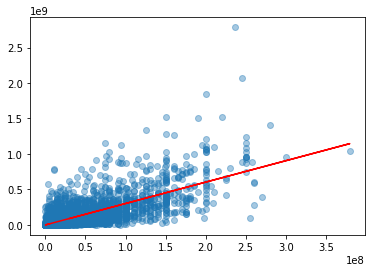

In [20]:
plt.scatter(x_dados,y_dados, alpha=0.4)
plt.plot(x_dados, ypredict, color='red')
plt.show()

### Análise de resíduos

Ao analisar os gráficos abaixo, é possível observar que os residuos nao se distribuem normalmente e tem um sigma2 variavel, uma vez que a variancia dos residuos esta crescendo conforme y aumenta, indicando a nao homocedasticidade suposta pelo modelo de regressao

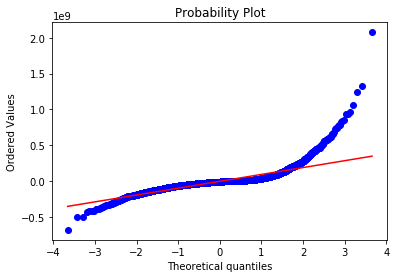

In [21]:
stats.probplot(results.resid, dist='norm', plot=plt);

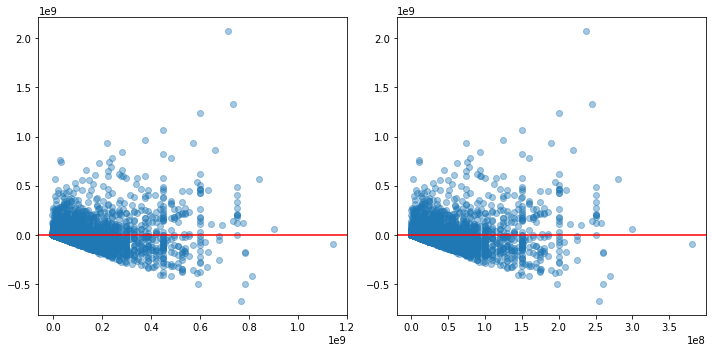

In [22]:
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(ypredict, results.resid,alpha=0.4);
plt.axhline(y=0,color='r',linestyle='-'); 

plt.subplot(122)
plt.scatter(x_dados, results.resid, alpha=0.4);
plt.axhline(y=0,color='r',linestyle='-'); 

plt.tight_layout()
plt.show()

## Conclusão do modelo de Regressão Linear simples

A conclusão do ajuste anterior é que as suposições de normalidade
(via teste de hipóteses) e de homocedasticidade (graficamente) não
estão válidas.
Logo, o modelo ajustado que relaciona como a receita de um filme  pode ser explicado pelo orçamento **não** deve ser considerado para
tomada de decisões.

## Regressão Linear Múltipla

Diferentemente da Regressão Linear Simples, é possível descrever as relacoes entre multiplas variáveis. No entanto, assim como na sua versao mais simples, este modelo precisa de variaveis quantitativas como entrada. Desta forma, vamos aplicar o modelo em dois contextos, utilizando apenas as variáveis quantitativas e utilizando todas as variáveis que considerarmos relevantes, para enfim termos uma conclusao do modelo.

Removemos as variáveis 
* **adult** - Os filmes considerados adultos correspondiam a uma parte muito pequena da amostra e portanto essa variavel nao iria refletir na nossa analise
* homepage - nao 
* original_title, poster_path, imdb_id e video não trazem informacoes que possam ser usadas em nosso modelo de predicao
* status - como queremos prever a receita de um filme, iremos analisar apenas os filmes que já foram lançados, que correspondem a maior parte do dataset


Podemos transformar em tem ou nao tem :
* homepage                  object


As variáveis que consideramos relevantes, em um primeiro momento, para prever a receita de um filme sao:

* belongs_to_collection     object
* budget                     int64
* genres                    object
* original_language         object
* overview                  object
* popularity                object
* production_companies      object
* production_countries      object
* release_date              object
* revenue                  float64
* runtime                  float64
* spoken_languages          object
* tagline                   object
* title                     object
* vote_average             float64
* vote_count               float64



In [23]:
met = metadados[['title', 'budget', 'runtime', 'revenue', 'vote_average', 'vote_count', 'popularity']]#.set_index('title')
met.describe()

,budget,runtime,revenue,vote_average,vote_count
count,4.546300e+04,45203.000000,4.546000e+04,45460.000000,45460.000000
mean,4.224579e+06,94.128199,1.120935e+07,5.618207,109.897338
std,1.742413e+07,38.407810,6.433225e+07,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,85.000000,0.000000e+00,5.000000,3.000000
50%,0.000000e+00,95.000000,0.000000e+00,6.000000,10.000000
75%,0.000000e+00,107.000000,0.000000e+00,6.800000,34.000000
max,3.800000e+08,1256.000000,2.787965e+09,10.000000,14075.000000


In [24]:
# definindo as variaveis quanti a serem utilizadas
met['popularity'] = met['popularity'].astype('float')
quant = ['budget', 'runtime', 'revenue', 'vote_average', 'vote_count', 'popularity']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
met.head()

,title,budget,runtime,revenue,vote_average,vote_count,popularity
0,Toy Story,30000000,81.0,373554033.0,7.7,5415.0,21.946943
1,Jumanji,65000000,104.0,262797249.0,6.9,2413.0,17.015539
2,Grumpier Old Men,0,101.0,0.0,6.5,92.0,11.712900
3,Waiting to Exhale,16000000,127.0,81452156.0,6.1,34.0,3.859495
4,Father of the Bride Part II,0,106.0,76578911.0,5.7,173.0,8.387519


In [26]:
met.loc[:,quant] = met.loc[:,quant].replace(0, np.nan)
met = met.loc[:,quant].dropna()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
quant_x = quant.copy()
quant_x.remove('revenue')
quant_x

['budget', 'runtime', 'vote_average', 'vote_count', 'popularity']

In [28]:
### Função utilitária para fazer a regressão com constante adicionada
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [29]:
#definindo as variaveis explicativas e dependentes, e garantindo que todos estejam em formato de float
X = met.loc[:, quant_x].astype(float)
Y = met.revenue.astype(float)

results = regress(X,Y)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     2705.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:11:25   Log-Likelihood:            -1.0573e+05
No. Observations:                5362   AIC:                         2.115e+05
Df Residuals:                    5356   BIC:                         2.115e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.679e+07   9.94e+06     -2.695      0.007   -4.63e+07    -7.3e+06
budget           1.7435      0.039     44.434      0.000       1.667       1.820
runtime       3.209e+04   6.11e+04      0.525      0.599   -8.76e+04    1.52e+05
vote_average  4.833e+05   1.57e+06      0.309      0.758   -2.59e+06    3.55e+06
vote_count    6.431e+04   1396.501     46.050      0.000    6.16e+04     6.7e+04
popularity    9.395e+05   9.98e+04      9.417      0.000    7.44e+05    1.14e+06
==============================================================================
Omnibus:                     3775.062   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           241953.029
Skew:                           2.713   Prob(JB):                         0.00
Kurtosis:                      35.458   Cond. No.                     4.21e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.21e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Para selecionar as variáveis mais significantes para o nosso modelo, utilizamos o método Stepwise. O código da função stepwise_selection abaixo foi obtido através deste link (https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447)

In [ ]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, Y)

print('resulting features:')
print(result)

A partir do resultado acima, temos como significantes as variáveis 'vote_count', 'budget' e 'popularity'. Vale ressaltar que é de certa forma incorreto prever a receita de um filme utilizando as variáveis de popularidade e numero de votos, mesmo que sejam significantes e bem correlacionados com a receita, uma vez que esses dados só são possíveis após o lancamento do filme.

### Com as variáveis quali

Para conseguirmos utilizar as variáveis quali em uma regressao linear, é preciso encodar elas. Para isso, vamos aplicar a técnica ... As variáveis a serem utilizadas sao:

* a list of film genres
* release date — split up into year and day of the year
* a list of spoken languages
* runtime
* a list of production companies
* a list of cast members
* a list of crew members
* keywords



In [30]:
met_quali = metadados['']

KeyError: ''

In [31]:
date = pd.to_datetime(metadados.loc[:,'release_date'].astype(str))
year = date.dt.year
week = date.dt.week

In [32]:
met.loc[:,'year'] = year.dropna().astype(int)
met.loc[:,'week'] = week.dropna().astype(int)

## Random Forest Classifier, Decision Tree Classifier e KNeighbors Classifier

Importando a biblioteca:

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from pprint import pprint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


FIT_MODELS = 1
PLOT_CONFUSION_MATRIXES = 1
PRECISION_AT_N = 1

In [34]:
if FIT_MODELS:
    
#Random Forest
    randf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators = 100)
    randf.fit(X, Y)

# Decision Tree
    tree = DecisionTreeClassifier(random_state=0)
    tree.fit(X, Y)
    
# KNearestNeighbors
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X, Y)

Armazenando os dados de forma mais facíl para utilização:

In [35]:
if FIT_MODELS:
    models = {'Random Forest': randf,
            'KNearestNeighbors': neigh,
            'Decision Tree': tree}
    for model_name, model in models.items():
        np.save('Assets/files/' + model_name, model, allow_pickle=True)
else:
    models = {}
    for k in ['Random Forest', 'KNearestNeighbors', 'Decision Tree']:
        models[k] = np.load('Assets/files/' + k + '.npy', allow_pickle=True)

## Analisando as classificações feitas:

A matriz de confusão abaixo mostra em mais detalhes os erros e acertos do classificador.

###### Obs: A função *plot_confusion_matrix* abaixo não é de nossa autoria, e sua versão original pode ser encontrada no seguinte endereço: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [36]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Greens, save_to_file = True):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save_to_file:
        plt.savefig('Assets/files/' + title + '.pdf')
    return ax

def multi_confusion_mtx(X, Y, model_dict):
    for k,v in model_dict.items():
        plot_confusion_matrix(Y, v.predict(X), classes=v.classes_,
                            title=k)
        plt.show()

def precision_at_n(model, n = 3, X_test = X, y_test = Y):
    prediction = model.predict_proba(X_test)
    prediction_at_n = []
    for k in prediction:
        prediction_at_n.append(pd.Series(k, index = CLASSES).nlargest(n).index.tolist())
    hits, misses = 0, 0
    for guess, answer in zip(prediction_at_n, y_test):
        if answer in guess:
            hits += 1
        else:
            misses += 1
    return hits/(hits+misses)

def show_guess(path, model):
    return pd.Series(model.predict_proba(show_example(path))[0], index = model.classes_).sort_values(ascending = False)

np.set_printoptions(precision=2)

In [38]:
for model_name, model in models.items():
    print("%s score of: %.5f" % (model_name, model.score(X, Y)))

Random Forest score of: 1.00000
KNearestNeighbors score of: 0.19657
Decision Tree score of: 1.00000
